In [45]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from PIL import Image

import scipy.misc

import dense_correspondence_manipulation.utils.utils as utils
utils.add_dense_correspondence_to_python_path()

import dense_correspondence
from dense_correspondence.evaluation.evaluation import *
import dense_correspondence.correspondence_tools.correspondence_plotter as correspondence_plotter
import dense_correspondence.correspondence_tools.correspondence_finder as correspondence_finder
from dense_correspondence.correspondence_tools.correspondence_finder import random_sample_from_masked_image, pinhole_projection_image_to_world
from dense_correspondence.dataset.dense_correspondence_dataset_masked import ImageType
from dense_correspondence.network.dense_correspondence_network import DenseCorrespondenceNetwork
import dense_correspondence.evaluation.plotting as dc_plotting
%matplotlib inline 
utils.set_cuda_visible_devices([0])


setting CUDA_VISIBLE_DEVICES =  0,


In [3]:
config_filename = os.path.join(utils.getDenseCorrespondenceSourceDir(), 'config', 
                               'dense_correspondence', 'evaluation', 'evaluation.yaml')
config = utils.getDictFromYamlFilename(config_filename)
dce = DenseCorrespondenceEvaluation(config)
DCE = DenseCorrespondenceEvaluation
dcn = dce.load_network_from_config("cup_bottlesauce_elephant_cat_pear_unit_8")
dataset = dcn.load_training_dataset()
camera_intrinsics = dataset.get_camera_intrinsics("elephant")

/home/davidtseng/pytorch-dense-correspondence/env/local/lib/python2.7/site-packages/torch/nn/modules/module.py:482: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.
  own_state[name].copy_(param)


Using SpartanDataset:
   - in train mode
   - number of scenes 5
   - total images:     18650


In [4]:
def match_index_and_norm_diff(query, features):
    """
    Assumes that query and features both have shape (N, 2).
    query: ndarray (D,)
    features: ndarray (N, D)    
    """
    
    norm_diffs = np.sqrt(np.sum(np.square(features - query), axis=1))
    best_match_index = np.argmin(norm_diffs)
    best_match_diff = norm_diffs[best_match_index]
    return np.array([best_match_index, best_match_diff])

def simple_match(f1, f2):
    """Simple brute force matching between features1 and features2.
    f1: ndarray of shape (N, ... )
    f2: ndarray of shape (N, ....)
    Returns indices of matches, sorted by norm diff
    """
    
    f1 = f1.reshape((f1.shape[0], -1)) 
    f2 = f2.reshape((f2.shape[0], -1))
    
    f1_matches = np.apply_along_axis(lambda x: match_index_and_norm_diff(x, f2), 1, f1)
    f2_matches = np.apply_along_axis(lambda x: match_index_and_norm_diff(x, f1), 1, f2)
    
    best_matches = []
    
    for i in range(f1_matches.shape[0]):
        norm_diff = f1_matches[i, 1]
        best_match_index = int(f1_matches[i, 0])
        f2_matches[best_match_index, 0]
        if f2_matches[best_match_index, 0] == i: # If they're the best matches of each other
            best_matches.append((i, best_match_index, norm_diff))
            
    return best_matches


def draw_orb_matches(img1, kp1, des1, img2, kp2, des2, match_type="hamming", num_matches=10):
    dist = 0.01 # placeholder constant for opencv

    if match_type == "hamming": 
        print("Using openCV norm_hamming")
        # create BFMatcher object
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

        # Match descriptors.    
        matches = bf.match(des1,des2)
    else:
        print("Using simple match")
        best_matches_lst = simple_match(des1, des2)
        matches = [cv2.DMatch(x[0], x[1], dist) for x in best_matches_lst]

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)

    # Draw first 10 matches.
    img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:num_matches], None, flags=2)

    plt.figure(figsize = (20, 10))
    plt.imshow(img3)
    plt.show()
    
def run_dcn_on_image(dcn, dataset, img):
    """
    Run DCN on PIL img. use of dataset is a hack, just need to ge the descriptor image stats 
    which actually just uses a constant for std and mean. 
    """
    rgb_a_tensor = dataset.rgb_image_to_tensor(img)
    res_a = dcn.forward_single_image_tensor(rgb_a_tensor).data.cpu().numpy()
    descriptor_image_stats = dcn.descriptor_image_stats
    res_a_norm = dc_plotting.normalize_descriptor(res_a, descriptor_image_stats["mask_image"])
    return res_a_norm

def run_ORB(heap_name, target_name, num_matches=5):
    """Run baseline ORB. """
    orb = cv2.ORB_create()

    target_img = Image.open("images/targets/{}/target_depth.png".format(target_name)).convert('RGB')
    target = np.array(target_img)

    # target = target * target_mask

    heap_img = Image.open("images/heaps/{}/heap_depth.png".format(heap_name)).convert('RGB')
    heap = np.array(heap_img)

    kp1, des1 = orb.detectAndCompute(target,None)
    kp2, des2 = orb.detectAndCompute(heap,None)
    
    draw_orb_matches(target, kp1, des1, heap, kp2, des2, num_matches=num_matches)

def run_ORB_and_dense_descriptors(dcn, dataset, heap_name, target_name, num_matches=5):
    """Use ORB keypoints + dense descriptors. """
    orb = cv2.ORB_create()

    target_img = Image.open("images/targets/{}/target_depth.png".format(target_name)).convert('RGB')
    target = np.array(target_img)
    target_descriptors = run_dcn_on_image(dcn, dataset, target_img)
    
    heap_img = Image.open("images/heaps/{}/heap_depth.png".format(heap_name)).convert('RGB')
    heap = np.array(heap_img)
    heap_descriptors = run_dcn_on_image(dcn, dataset, heap_img)
    
    # be careful, OpenCV format is  (u,v) = (right, down)
    kp1_map = lambda x: target_descriptors[x[1], x[0]]
    kp2_map = lambda x: heap_descriptors[x[1], x[0]]

    # # find the keypoints with ORB
    kp1 = orb.detect(target,None)
    kp1_array = np.array([x.pt for x in kp1]).reshape(-1, 2).astype(np.int)
    des1 = np.apply_along_axis(kp1_map, 1, kp1_array)
    
    kp2 = orb.detect(heap,None)
    kp2_array = np.array([x.pt for x in kp2]).reshape(-1, 2).astype(np.int)
    des2 = np.apply_along_axis(kp2_map, 1, kp2_array)
    draw_orb_matches(target, kp1, des1, heap, kp2, des2, num_matches=num_matches, match_type="simple")
    
    

def run_dense_descriptor_original_match(dcn, dataset, heap_name, target_name, num_matches=5, patch_size=None):
    """Use the original dense descriptor sampling + matching method"""
    target_img = Image.open("images/targets/{}/target_depth.png".format(target_name)).convert('RGB')
    target = np.array(target_img)
    target_descriptors = run_dcn_on_image(dcn, dataset, target_img)
    target_mask = np.load("images/targets/{}/target_mask.npy".format(target_name)).astype(np.bool)
    
    heap_img = Image.open("images/heaps/{}/heap_depth.png".format(heap_name)).convert('RGB')
    heap = np.array(heap_img)
    heap_descriptors = run_dcn_on_image(dcn, dataset, heap_img)
    heap_mask = np.load("images/heaps/{}/heap_mask.npy".format(heap_name)).astype(np.bool)
    
    DCE.single_image_pair_qualitative_analysis(dcn, dataset, target, heap, target_mask, heap_mask, num_matches, patch_size)

    
def compute_PPT_feature(uv_A, uv_B, img, des, camera_intrinsics, distance_weight=1):
    """
    Computes PPT feature from uv_A and uv_B. These are in UV (openCV) format. (uv_A, uv_B) 
    should get the same PPT feature as (uv_B, uv_A). Camera intrinsics should be in one of 
    the first cells. 
    
    img is the input "depth rgb" image. Bc it was generated with img = actual_depth / 0.2, 
    the actual depth is img * 0.2
    
    Descriptor is [weight * distance, des_A...., desB....]
    """
    
    # !! Still need to figure out what the distance_weight should be 
    
    if uv_B[0] < uv_A[0]:
        uv_A, uv_B = uv_B, uv_A
    elif uv_B[0] == uv_A[0] and uv_B[1] < uv_A[1]:
        uv_A, uv_B = uv_B, uv_A
    
    # !! HACK !! 
    depth_A = 0.2 * img[uv_A[1], uv_A[0], 0]
    depth_B = 0.2 * img[uv_B[1], uv_B[1], 0]
    des_A = des[uv_A[1], uv_A[0], :]
    des_B = des[uv_B[1], uv_B[0], :]
    
    # Temporary HACK: currently using pixel distance instead of physical distance
#     pos_in_camera_frameA = pinhole_projection_image_to_world(uv_A, depth_A, camera_intrinsics.K)
#     pos_in_camera_frameB = pinhole_projection_image_to_world(uv_B, depth_B, camera_intrinsics.K)

#     distance = np.sqrt(np.sum((pos_in_camera_frameA - pos_in_camera_frameB)**2))
    dist = lambda x, y: np.sqrt((x[0]-y[0])**2 + (x[1]-y[1])**2)
    distance = dist(uv_A, uv_B)
    ppt = np.concatenate((np.array([distance_weight * distance]), des_A, des_B))

    return ppt


def generate_PPT_samples(img, des, mask, num_samples=5):
    """Generate np.array of shape (N**2 x PPT_dim) sample features. """
    dist = lambda x, y: np.sqrt((x[0]-y[0])**2 + (x[1]-y[1])**2)
    mask = mask[:, :, 0].astype(np.int)    
    sampled_idx_list = random_sample_from_masked_image(mask, num_samples)
    
    # If the list is empty, return an empty list
    if len(sampled_idx_list) == 0:
        return dataframe_list
    
    ppt_lst = []
    coord_lst = []
    
    for i in range(num_samples):
        for j in range(i+1, num_samples):            
            uv_A = [sampled_idx_list[1][i], sampled_idx_list[0][i]]
            uv_B = [sampled_idx_list[1][j], sampled_idx_list[0][j]]
            if dist(uv_A, uv_B) > 20: # Basic: Increase pixel distance. 
                                      # TODO: Increase physical spatial difference
                                      # TODO: Increase feature space difference
                coord_lst.append((uv_A, uv_B))
                ppt_lst.append(compute_PPT_feature(uv_A, uv_B, img, des, camera_intrinsics))
                
    ppt_lst = np.array(ppt_lst)
    coord_lst = np.array(coord_lst)
    sort_by_distance_i = ppt_lst[:, 0].argsort()
    ppt_lst, coord_lst = ppt_lst[sort_by_distance_i], coord_lst[sort_by_distance_i]
    
    return ppt_lst, coord_lst


def run_PPT_match(dcn, dataset, heap_name, target_name, num_samples):
    target_img = Image.open("images/targets/{}/target_depth.png".format(target_name)).convert('RGB')
    target = np.array(target_img)
    target_descriptors = run_dcn_on_image(dcn, dataset, target_img)
    target_mask = np.load("images/targets/{}/target_mask.npy".format(target_name)).astype(np.bool)

    heap_img = Image.open("images/heaps/{}/heap_depth.png".format(heap_name)).convert('RGB')
    heap = np.array(heap_img)
    heap_descriptors = run_dcn_on_image(dcn, dataset, heap_img)
    heap_mask = np.load("images/heaps/{}/heap_mask.npy".format(heap_name)).astype(np.bool)
    obj1_mask = np.load("images/heaps/{}/obj1_mask.npy".format(heap_name)).astype(np.bool)
    obj2_mask = np.load("images/heaps/{}/obj2_mask.npy".format(heap_name)).astype(np.bool)

    target_PPT, target_PPT_coords = generate_PPT_samples(target, target_descriptors, target_mask)
    obj1_PPT, obj1_PPT_coords = generate_PPT_samples(target, target_descriptors, obj1_mask, num_samples)
    obj2_PPT, obj2_PPT_coords = generate_PPT_samples(target, target_descriptors, obj2_mask, num_samples)
    
    
    
        
#     target_obj1 = sorted(simple_match(target_PPT, obj1_PPT), key=lambda x:x[2])
#     target_obj2 = sorted(simple_match(target_PPT, obj2_PPT), key=lambda x:x[2])

# def draw_orb_matches_FLANN(img1, kp1, des1, img2, kp2, des2, num_matches=10):
#     # FLANN parameters
#     FLANN_INDEX_KDTREE = 0
#     index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
#     search_params = dict(checks=50)   # or pass empty dictionary

#     flann = cv2.FlannBasedMatcher(index_params,search_params)

#     matches = flann.knnMatch(des1,des2,k=2)

#     # Need to draw only good matches, so create a mask
#     matchesMask = [[0,0] for i in xrange(len(matches))]

#     # ratio test as per Lowe's paper
#     for i,(m,n) in enumerate(matches):
#         if m.distance < 0.7*n.distance:
#             matchesMask[i]=[1,0]

#     draw_params = dict(matchColor = (0,255,0),
#                        singlePointColor = (255,0,0),
#                        matchesMask = matchesMask,
#                        flags = 0)

#     img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)

#     plt.imshow(img3,),plt.show()
    


In [49]:
target_name = "elephant"

target_img = Image.open("images/targets/{}/target_depth.png".format(target_name)).convert('RGB')
target = np.array(target_img)
target_descriptors = run_dcn_on_image(dcn, dataset, target_img)
target_mask = np.load("images/targets/{}/target_mask.npy".format(target_name)).astype(np.bool)

# target_depth_shifted_2 is target_depth shifted to the right by 100 pixels
heap_img = Image.open("images/targets/{}/target_depth_shifted2.png".format(target_name)).convert('RGB')
heap = np.array(heap_img)
heap_descriptors = run_dcn_on_image(dcn, dataset, heap_img)
obj1_mask = (heap[:, :, 0] != 0).astype(int)*255
obj1_mask = np.stack((obj1_mask, obj1_mask, obj1_mask), axis=2)

# coords should be in UV (right, down), might want to double check that 
target_PPT, target_PPT_coords = generate_PPT_samples(target, target_descriptors, target_mask, num_samples=100)
obj1_PPT, obj1_PPT_coords = generate_PPT_samples(target, target_descriptors, obj1_mask, num_samples=100)

target_obj1 = sorted(simple_match(target_PPT, obj1_PPT), key=lambda x:x[2])
print(target_obj1)

# plt.imshow(target)
# plt.scatter(x=[100], y=[200], c='r', s=40)



normalizing descriptor norm
202
202
normalizing descriptor norm
[(3457, 592, 0.07813935728023584), (3172, 651, 0.1220497014052647), (3451, 1467, 0.2141212986351765), (4864, 588, 0.22499355206472518), (3166, 1526, 0.2337483710877155), (517, 582, 0.5757234150545953), (556, 604, 0.5773391127312175), (809, 1479, 0.5930034413563545), (3069, 1539, 0.5988688481476321), (634, 1801, 0.601794773138267), (3082, 1542, 0.613990250165848), (3072, 664, 0.6151099662692883), (3265, 1335, 0.6371265705983997), (3074, 296, 0.6381270919742578), (271, 667, 0.6400260307526753), (2427, 2718, 0.6403861026256534), (1272, 608, 0.6404583515097808), (3941, 1864, 0.642742321298845), (3937, 306, 0.6477049284116942), (3605, 3008, 0.6509744439186889), (1767, 665, 0.6518872526201894), (1099, 1540, 0.666750139460968), (2453, 989, 0.6849632816954427), (222, 2688, 0.6852652385796171), (2448, 2952, 0.6864159430907053), (2422, 2976, 0.6883644504486273), (1223, 2981, 0.7099263617387195), (3093, 596, 0.7260857206515892), (783

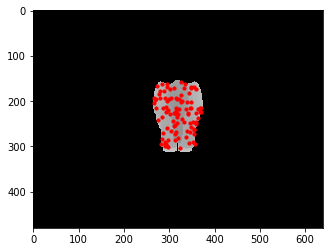

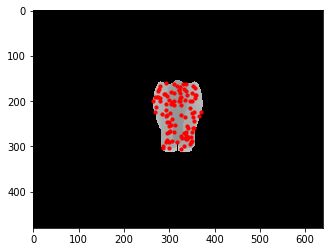

In [60]:
plt.imshow(target)
samples = random_sample_from_masked_image(target_mask, 100)
plt.scatter(x=samples[1], y=samples[0], c='r', s=10)
plt.figure()
plt.imshow(target)
samples = random_sample_from_masked_image(target_mask, 100)
plt.scatter(x=samples[1], y=samples[0], c='r', s=10)








# plt.imshow(target)
# plt.figure()
# target_cropped = target[:, 100:-100, :]
# plt.imshow(target_cropped)
# buf = np.zeros((480, 200, 3)).astype(int)
# target_shifted = np.concatenate((buf, target_cropped), axis=1)

# plt.figure()
# plt.imshow(target_shifted)
# scipy.misc.toimage(target_shifted, cmin=0.0, cmax=255).save("images/targets/{}/target_depth_shifted2.png".format(target_name))

In [56]:
print(target[200, 300])
print(heap[200, 400])


[155 155 155]
[155 155 155]


PPT original
[36.71856846  0.45305194  0.4035025   0.63015439  0.28411257  0.34761148
  0.69139443  0.65129332  0.72656468  0.43026629  0.37780975  0.64445514
  0.40343591  0.31418222  0.63802839  0.5988456   0.71938131]
PPT flipped
[36.71856846  0.45305194  0.4035025   0.63015439  0.28411257  0.34761148
  0.69139443  0.65129332  0.72656468  0.43026629  0.37780975  0.64445514
  0.40343591  0.31418222  0.63802839  0.5988456   0.71938131]
PPT shifted
[36.84374089  0.43626063  0.40246119  0.64004924  0.27191395  0.34373029
  0.69106305  0.65454549  0.73597417  0.44755718  0.39124969  0.58981838
  0.37841363  0.30476796  0.68934152  0.64406316  0.69215726]
diff


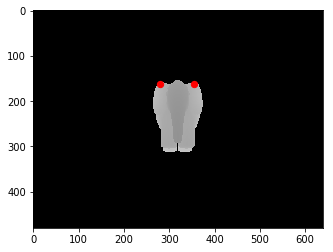

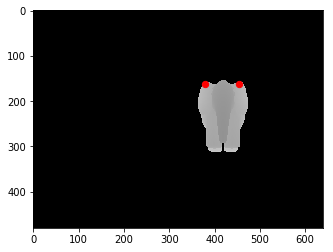

<Figure size 432x288 with 0 Axes>

In [57]:
plt.imshow(target)

uv_A = [279, 161]
uv_B = [355, 161]

ppt1 = compute_PPT_feature(uv_A, uv_B, target, target_descriptors, camera_intrinsics, distance_weight=1)
print("PPT original")
print(ppt1)
plt.scatter(x=[279, 355], y=[161, 161], c='r', s=40)
plt.figure()

plt.imshow(heap)

uv_A = [379, 161]
uv_B = [455, 161]
ppt2 = compute_PPT_feature(uv_A, uv_B, heap, heap_descriptors, camera_intrinsics, distance_weight=1)
plt.scatter(x=[379, 455], y=[161, 161], c='r', s=40)
plt.figure()
print("PPT shifted")
print(ppt2)
print("diff")


# plt.imshow(heap)
# plt.scatter(x=[485, 465], y=[68, 86], c='r', s=40)
# plt.figure()

# thoughts: 
# 
# only consider PPTs whose distance is within some threshold, and from there use simple_match 



ORB: 
Using openCV norm_hamming


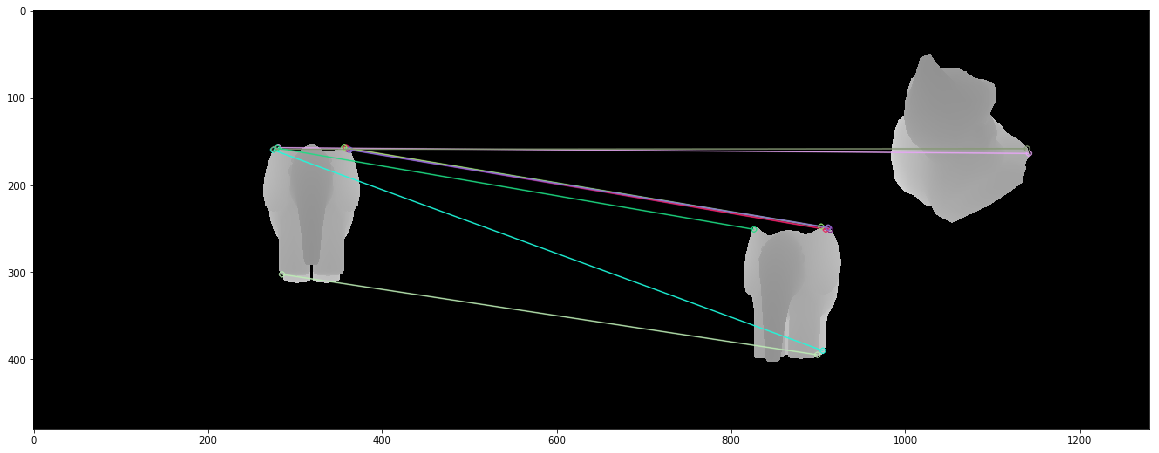

ORB + dense descriptors: 
normalizing descriptor norm
normalizing descriptor norm
Using simple match


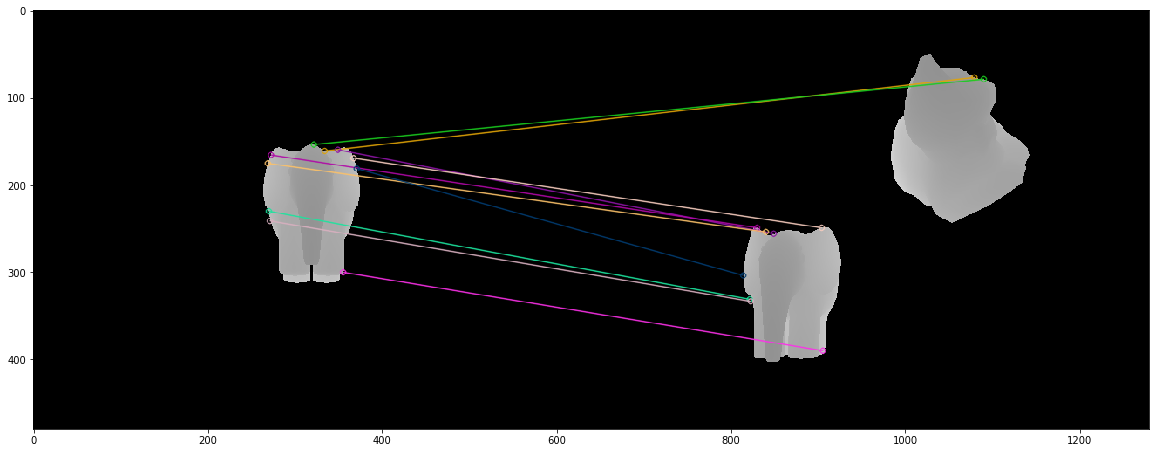

Original
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm


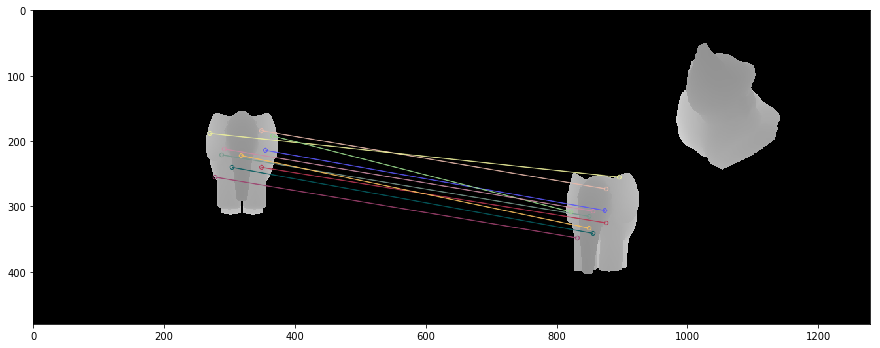

In [5]:
print("ORB: ")
run_ORB("elephant_cat", "elephant", num_matches=10)
print("ORB + dense descriptors: ")
run_ORB_and_dense_descriptors(dcn, dataset, "elephant_cat", "elephant", num_matches=10)
print("Original")
run_dense_descriptor_original_match(dcn, dataset, "elephant_cat", "elephant", num_matches=10, patch_size=None)

Basic ORB: 
Using openCV norm_hamming


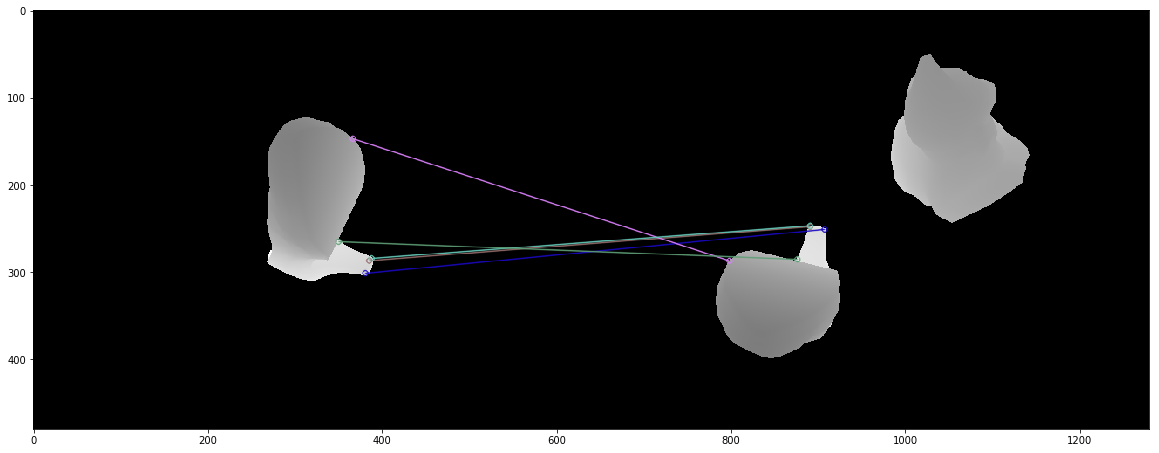

ORB + dense descriptors: 
normalizing descriptor norm
normalizing descriptor norm
Using simple match


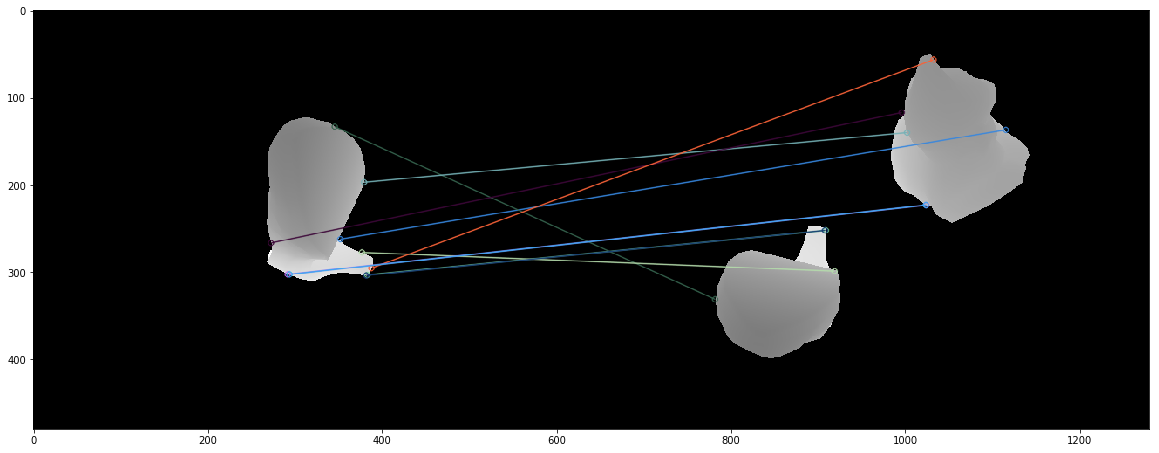

normalizing descriptor norm
normalizing descriptor norm
Using simple match


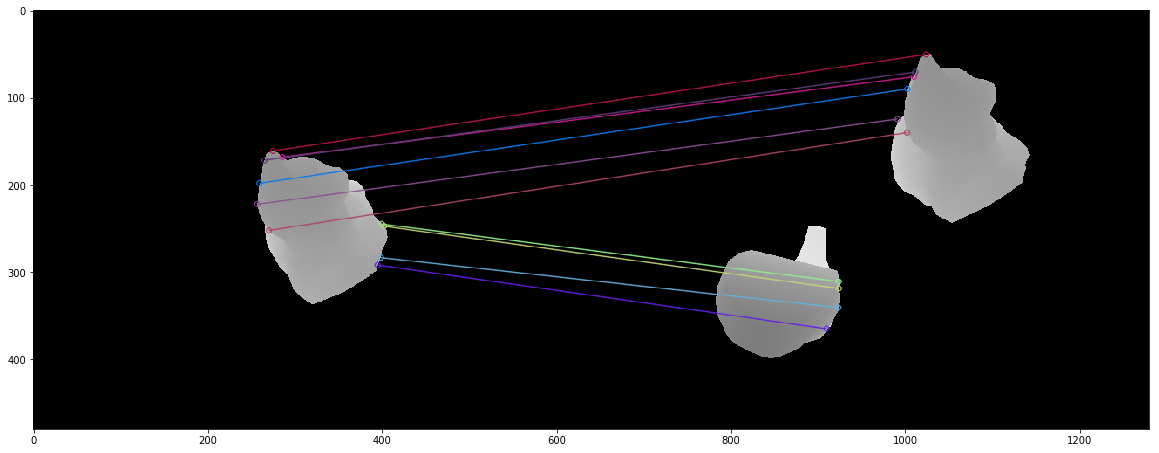

Original
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm


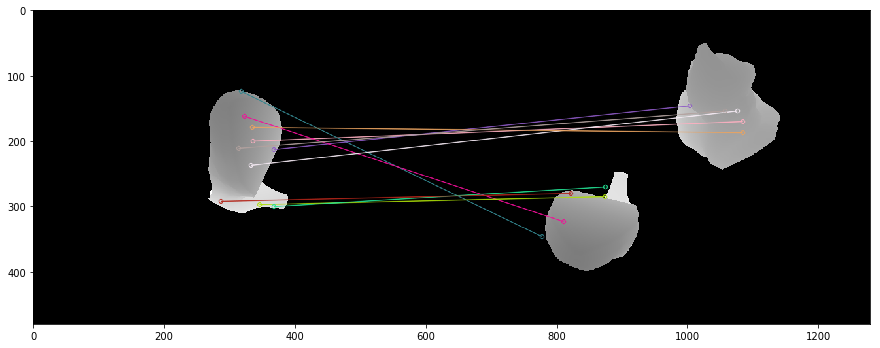

In [6]:
print("Basic ORB: ")
run_ORB("blackshoes_cat", "blackshoes", num_matches=5)
print("ORB + dense descriptors: ")
run_ORB_and_dense_descriptors(dcn, dataset, "blackshoes_cat", "blackshoes", num_matches=10)
run_ORB_and_dense_descriptors(dcn, dataset, "blackshoes_cat", "cat", num_matches=10)
print("Original")
run_dense_descriptor_original_match(dcn, dataset, "blackshoes_cat", "blackshoes", num_matches=10)

In [1]:
print("Basic ORB: ")
run_ORB("horse_spiky_screw", "horse", num_matches=10)
print("ORB + dense descriptors: ")
run_ORB_and_dense_descriptors(dcn, dataset, "horse_spiky_screw", "horse", num_matches=10)
run_ORB_and_dense_descriptors(dcn, dataset, "horse_spiky_screw", "spiky_screw", num_matches=10)
print("Original")
run_dense_descriptor_original_match(dcn, dataset, "horse_spiky_screw", "horse", num_matches=10)
run_dense_descriptor_original_match(dcn, dataset, "horse_spiky_screw", "spiky_screw", num_matches=10)

Basic ORB: 


NameError: name 'run_ORB' is not defined

Basic ORB: 
Using openCV norm_hamming


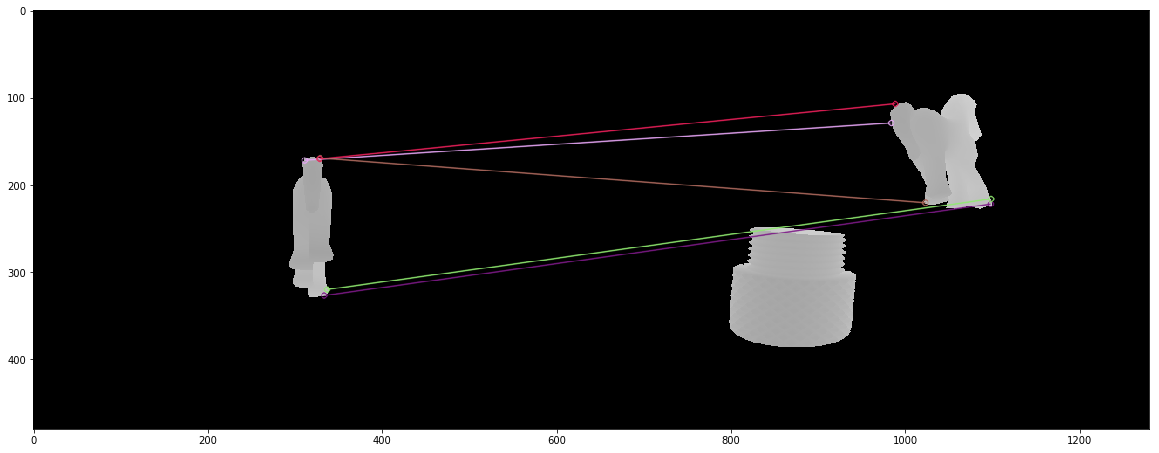

ORB + dense descriptors: 


/home/davidtseng/pytorch-dense-correspondence/env/local/lib/python2.7/site-packages/torch/nn/functional.py:1423: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.upsample instead.")


normalizing descriptor norm
normalizing descriptor norm
Using simple match


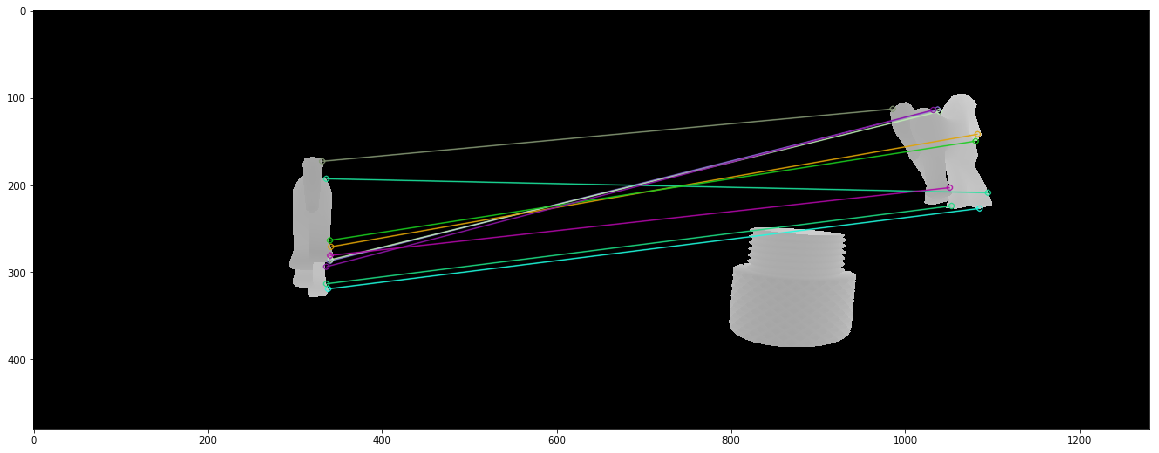

normalizing descriptor norm
normalizing descriptor norm
Using simple match


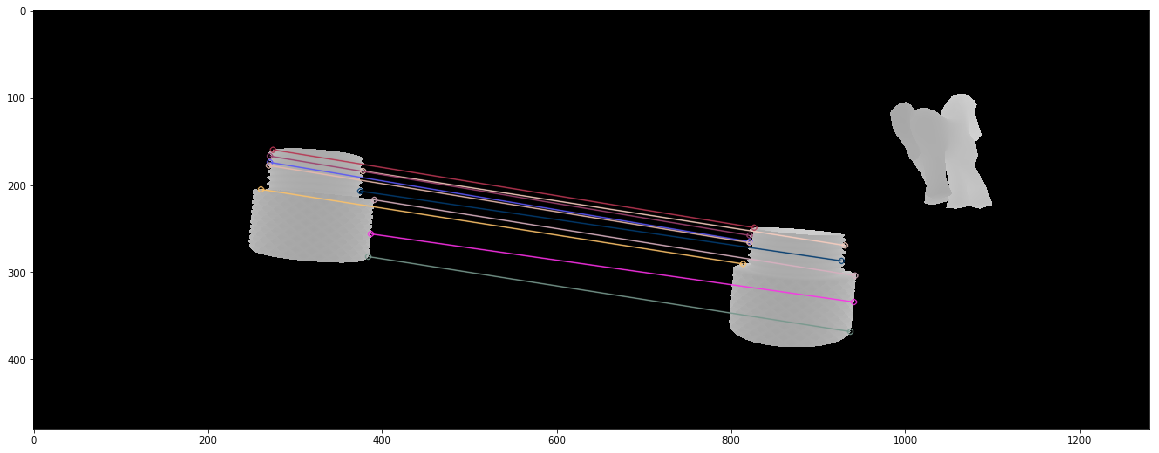

Original
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm


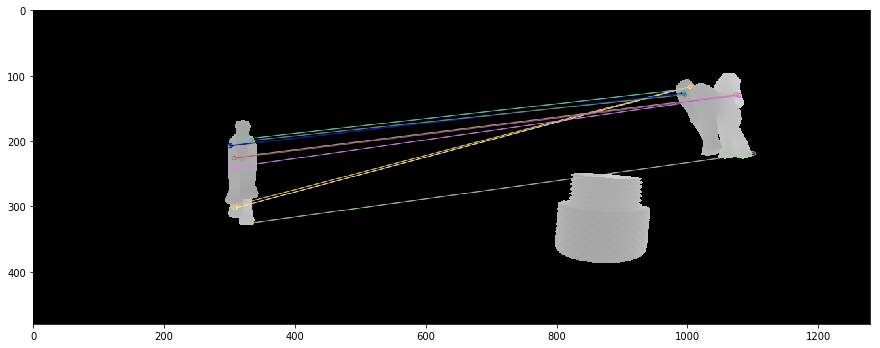

normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm


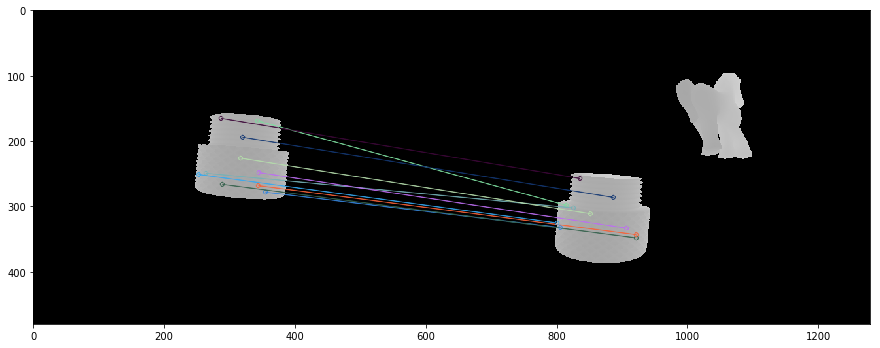

In [5]:
print("Basic ORB: ")
run_ORB("spiky_screw_horse", "horse", num_matches=5)
print("ORB + dense descriptors: ")
run_ORB_and_dense_descriptors(dcn, dataset, "spiky_screw_horse", "horse", num_matches=10)
run_ORB_and_dense_descriptors(dcn, dataset, "spiky_screw_horse", "spiky_screw", num_matches=10)
print("Original")
run_dense_descriptor_original_match(dcn, dataset, "spiky_screw_horse", "horse", num_matches=10)
run_dense_descriptor_original_match(dcn, dataset, "spiky_screw_horse", "spiky_screw", num_matches=10)

Basic ORB: 
Using openCV norm_hamming


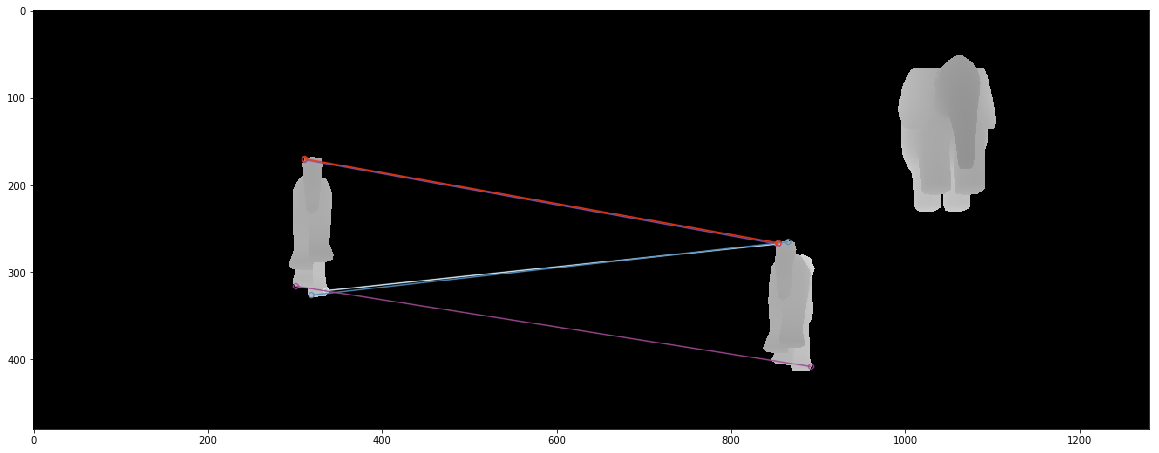

ORB + dense descriptors: 
normalizing descriptor norm
normalizing descriptor norm
Using simple match


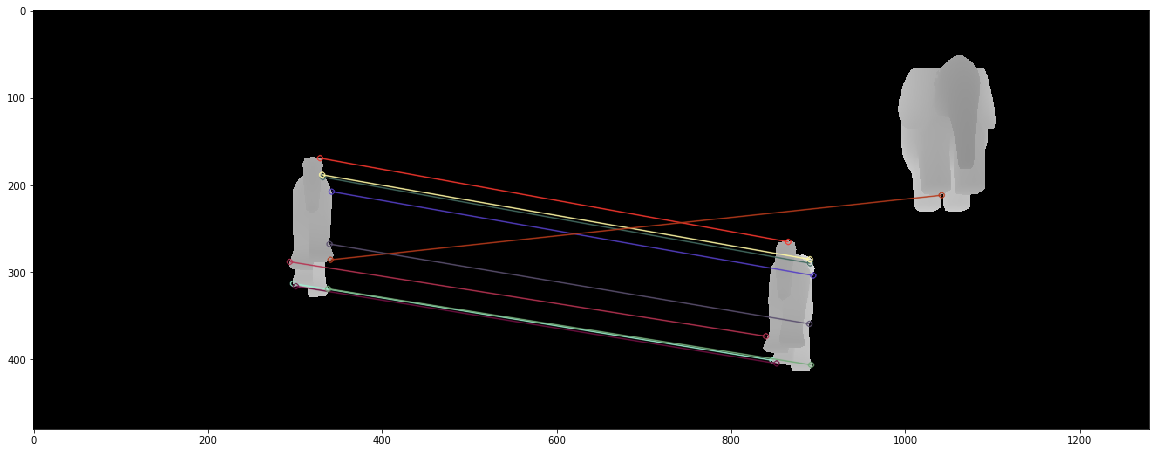

normalizing descriptor norm
normalizing descriptor norm
Using simple match


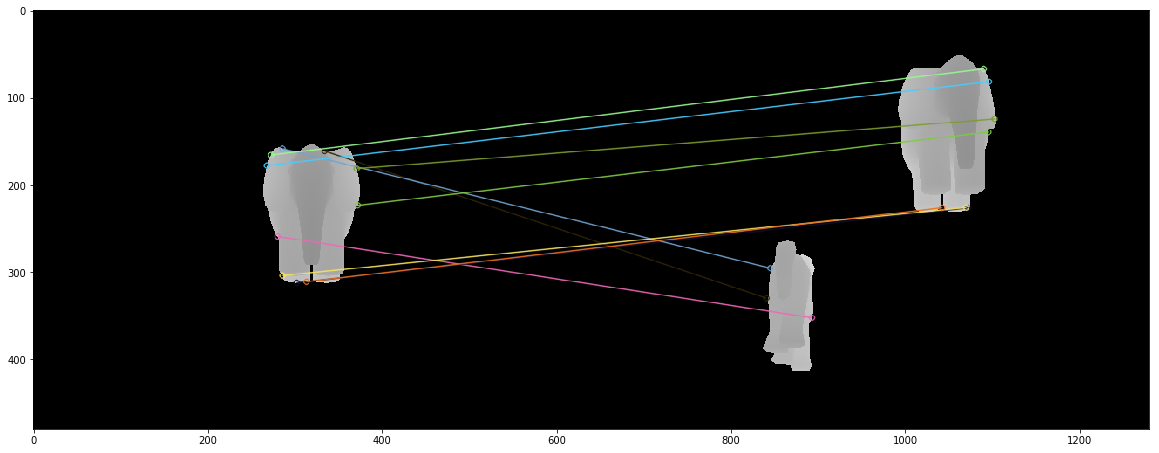

Original
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm


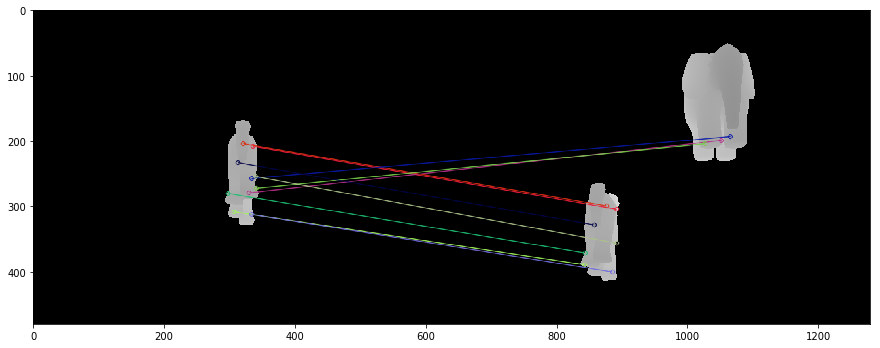

normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm


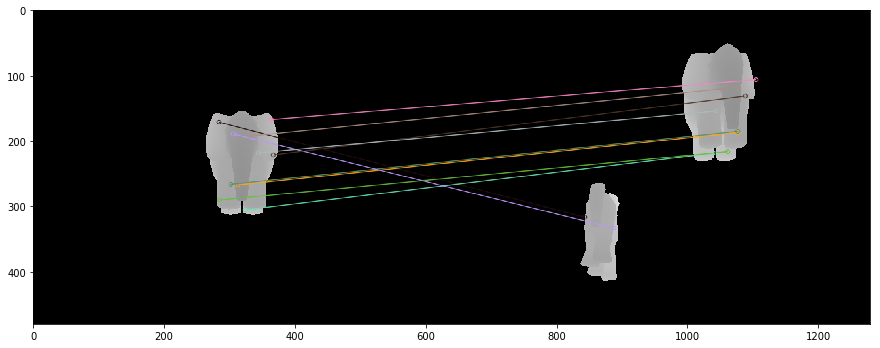

In [9]:
print("Basic ORB: ")
run_ORB("horse_elephant", "horse", num_matches=5)
print("ORB + dense descriptors: ")
run_ORB_and_dense_descriptors(dcn, dataset, "horse_elephant", "horse", num_matches=10)
run_ORB_and_dense_descriptors(dcn, dataset, "horse_elephant", "elephant", num_matches=10)
print("Original")
run_dense_descriptor_original_match(dcn, dataset, "horse_elephant", "horse", num_matches=10)
run_dense_descriptor_original_match(dcn, dataset, "horse_elephant", "elephant", num_matches=10)

Basic ORB: 
Using openCV norm_hamming


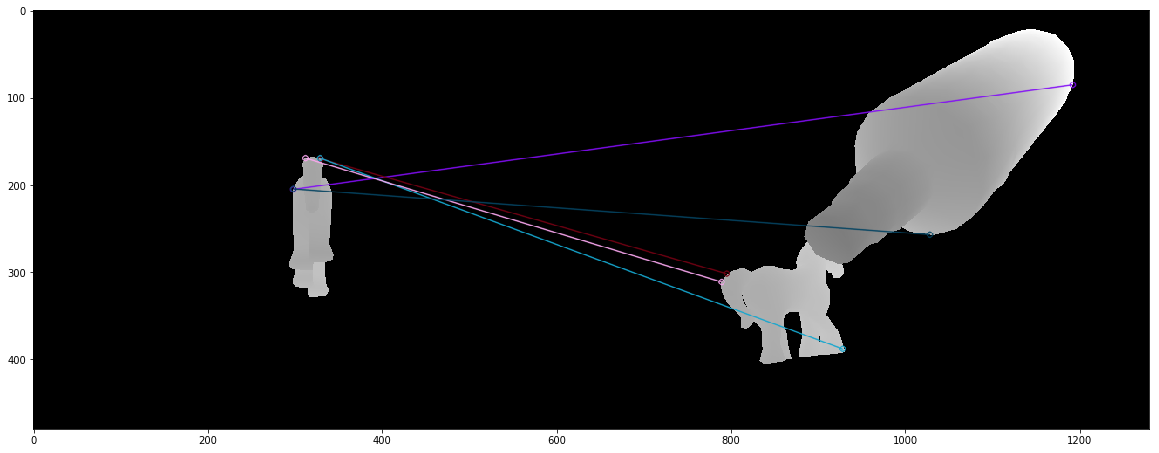

ORB + dense descriptors: 
normalizing descriptor norm
normalizing descriptor norm
Using simple match


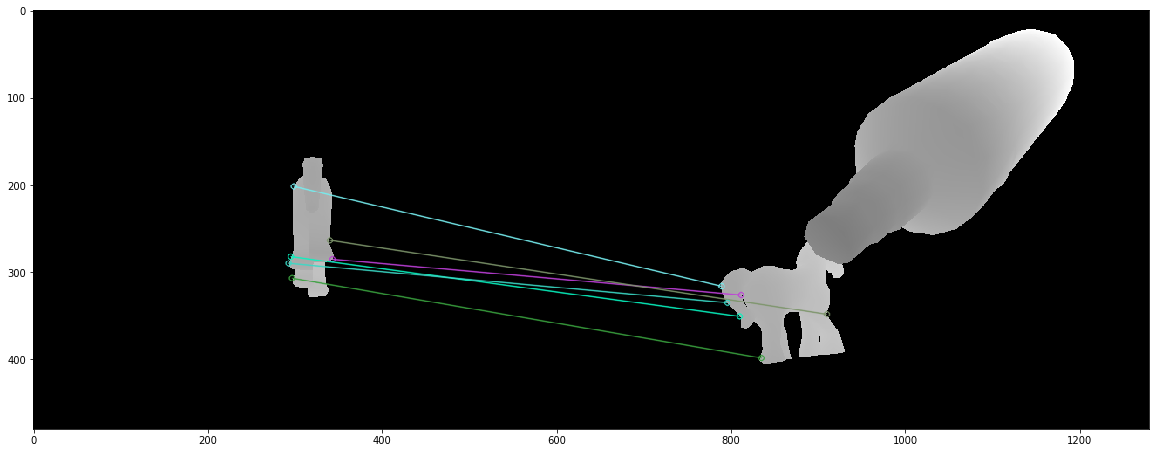

normalizing descriptor norm
normalizing descriptor norm
Using simple match


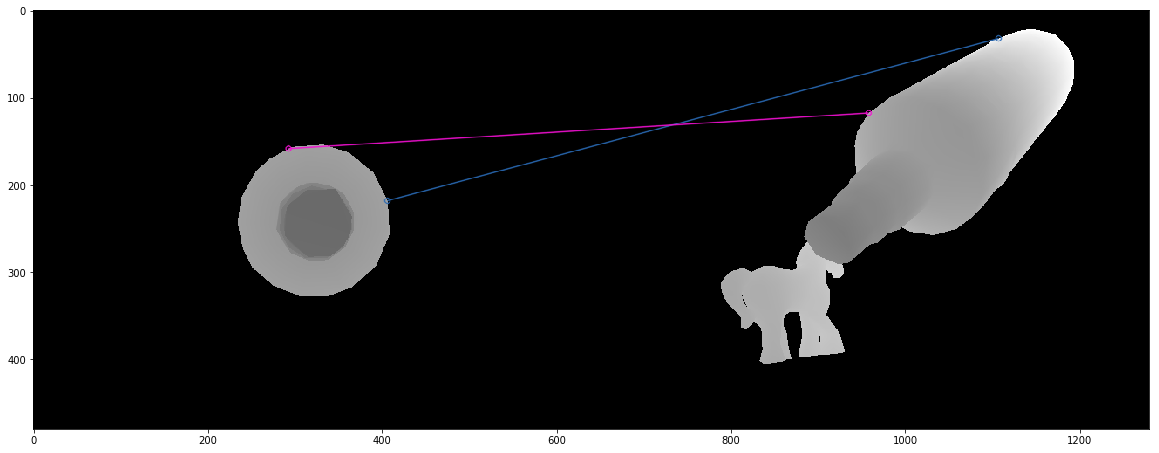

Original
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm


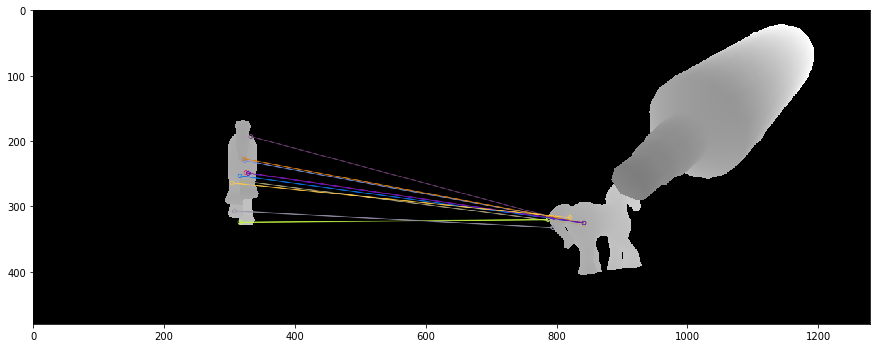

normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm


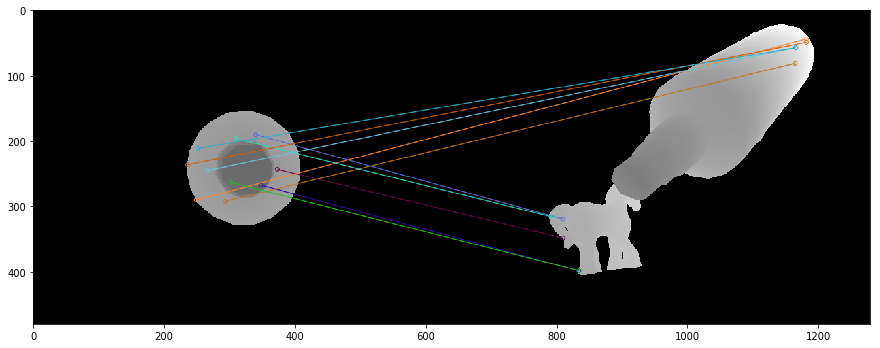

In [11]:
heap_name = "horse_bottle"
obj1 = "horse"
obj2 = "bottle"

print("Basic ORB: ")
run_ORB(heap_name, obj1, num_matches=5)
print("ORB + dense descriptors: ")
run_ORB_and_dense_descriptors(dcn, dataset, heap_name, obj1, num_matches=10)
run_ORB_and_dense_descriptors(dcn, dataset, heap_name, obj2, num_matches=10)
print("Original")
run_dense_descriptor_original_match(dcn, dataset, heap_name, obj1, num_matches=10)
run_dense_descriptor_original_match(dcn, dataset, heap_name, obj2, num_matches=10)

Basic ORB: 
Using openCV norm_hamming


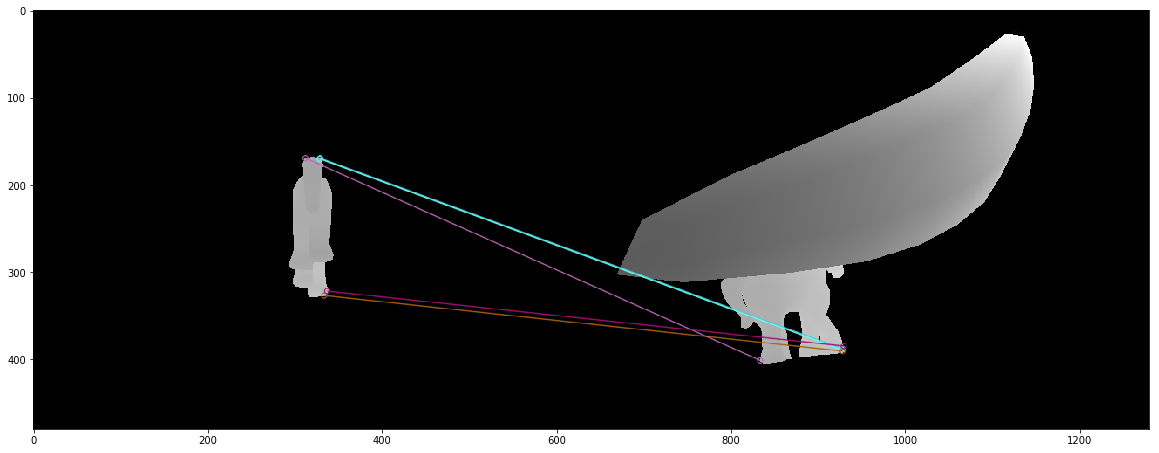

ORB + dense descriptors: 
normalizing descriptor norm
normalizing descriptor norm
Using simple match


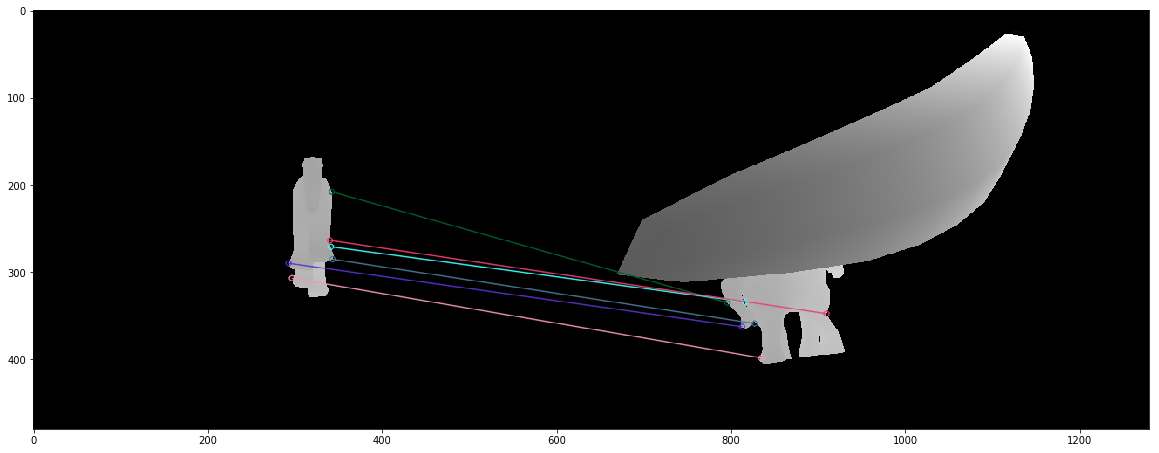

normalizing descriptor norm
normalizing descriptor norm
Using simple match


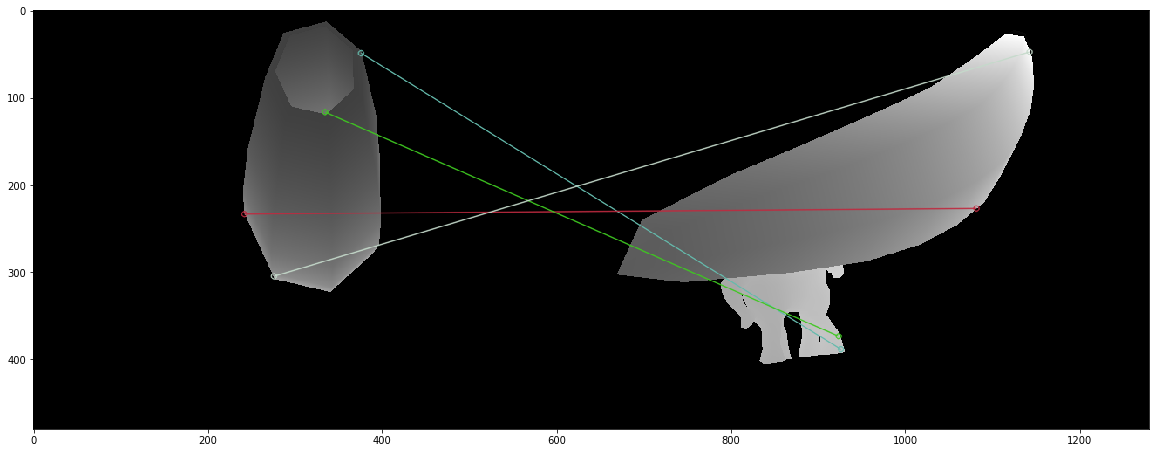

Original
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm


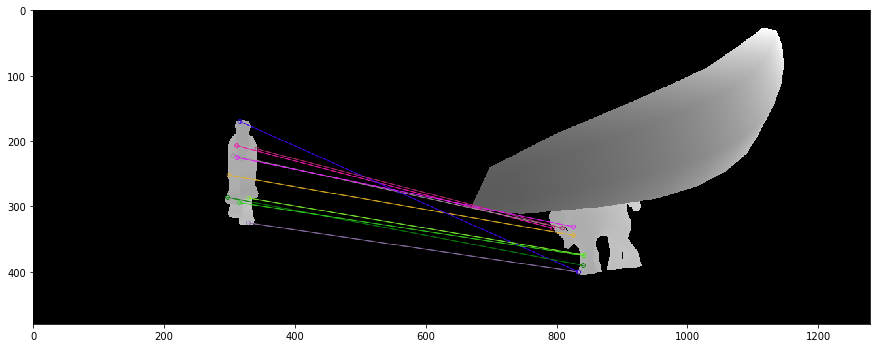

normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm


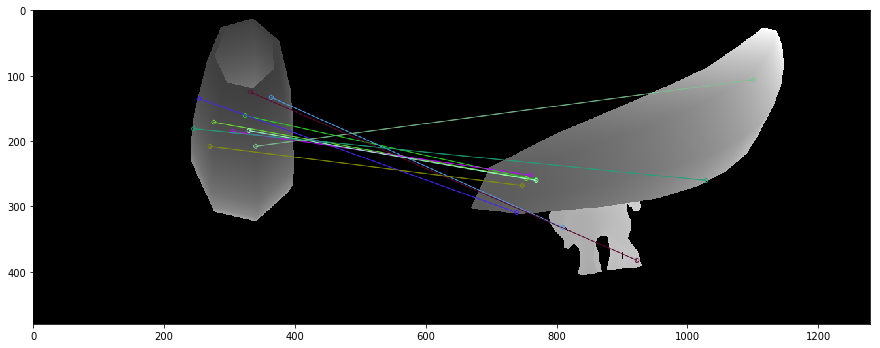

In [13]:
heap_name = "horse_banana"
obj1 = "horse"
obj2 = "banana"

print("Basic ORB: ")
run_ORB(heap_name, obj1, num_matches=5)
print("ORB + dense descriptors: ")
run_ORB_and_dense_descriptors(dcn, dataset, heap_name, obj1, num_matches=10)
run_ORB_and_dense_descriptors(dcn, dataset, heap_name, obj2, num_matches=10)
print("Original")
run_dense_descriptor_original_match(dcn, dataset, heap_name, obj1, num_matches=10)
run_dense_descriptor_original_match(dcn, dataset, heap_name, obj2, num_matches=10)

Basic ORB: 
Using openCV norm_hamming


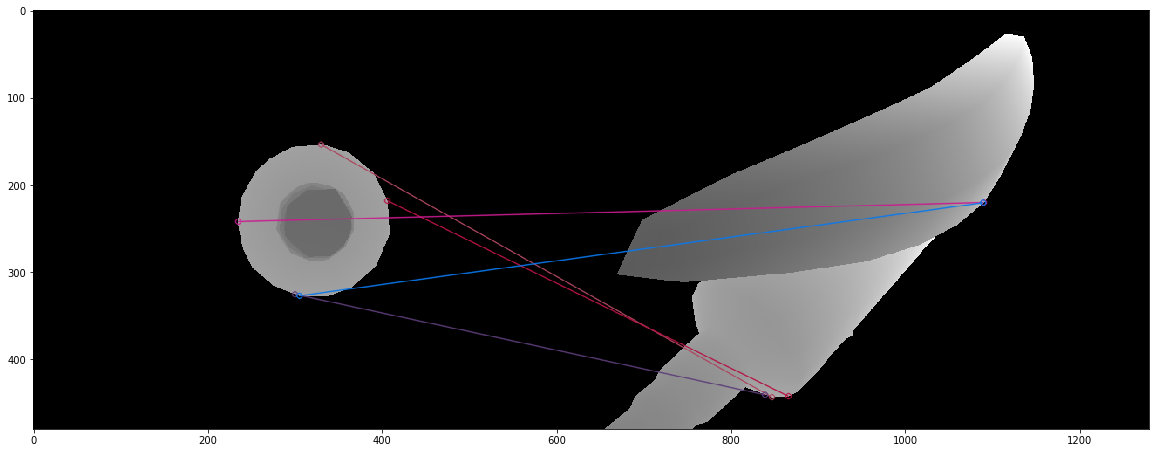

Using openCV norm_hamming


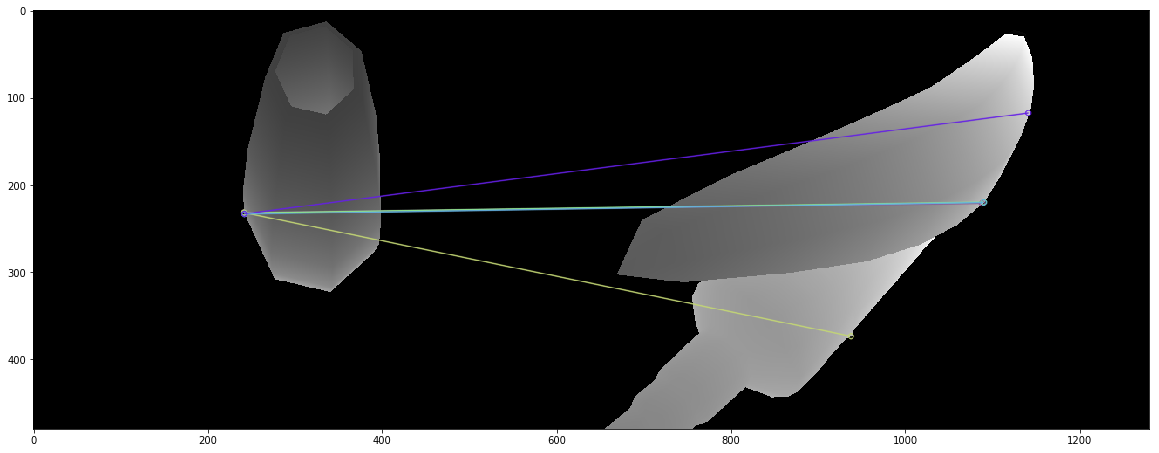

ORB + dense descriptors: 
normalizing descriptor norm
normalizing descriptor norm
Using simple match


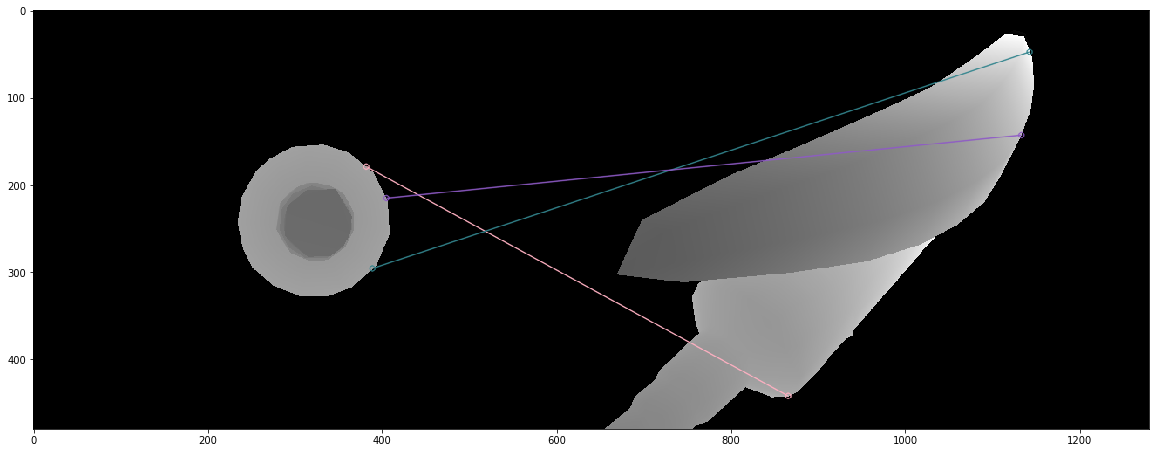

normalizing descriptor norm
normalizing descriptor norm
Using simple match


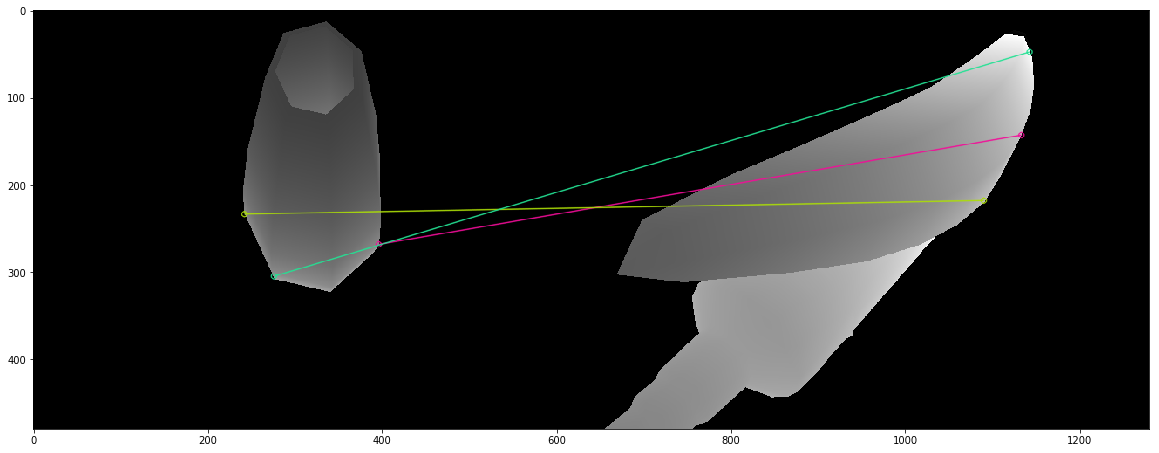

Original
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm


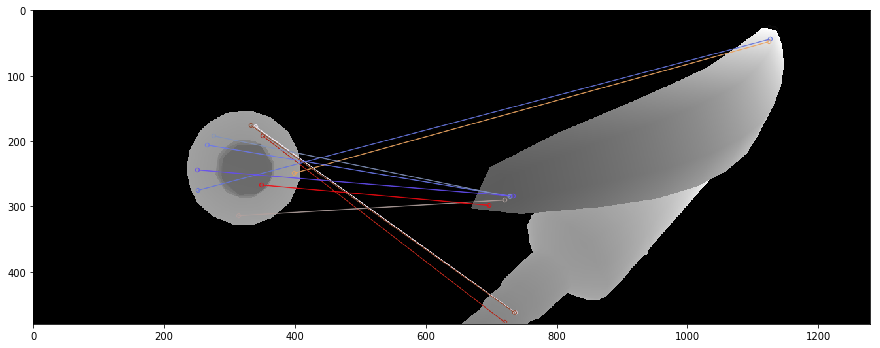

normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm
normalizing descriptor norm


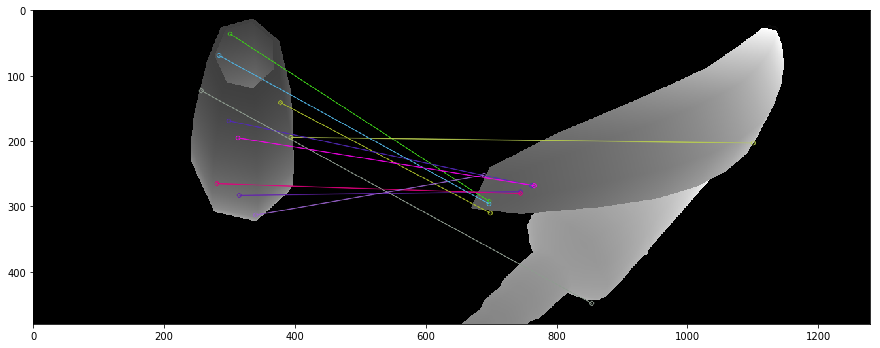

In [6]:
heap_name = "bottle_banana"
obj1 = "bottle"
obj2 = "banana"

print("Basic ORB: ")
run_ORB(heap_name, obj1, num_matches=5)
run_ORB(heap_name, obj2, num_matches=5)

print("ORB + dense descriptors: ")
run_ORB_and_dense_descriptors(dcn, dataset, heap_name, obj1, num_matches=10)
run_ORB_and_dense_descriptors(dcn, dataset, heap_name, obj2, num_matches=10)
print("Original")
run_dense_descriptor_original_match(dcn, dataset, heap_name, obj1, num_matches=10)
run_dense_descriptor_original_match(dcn, dataset, heap_name, obj2, num_matches=10)

# Random tests

Using simple match


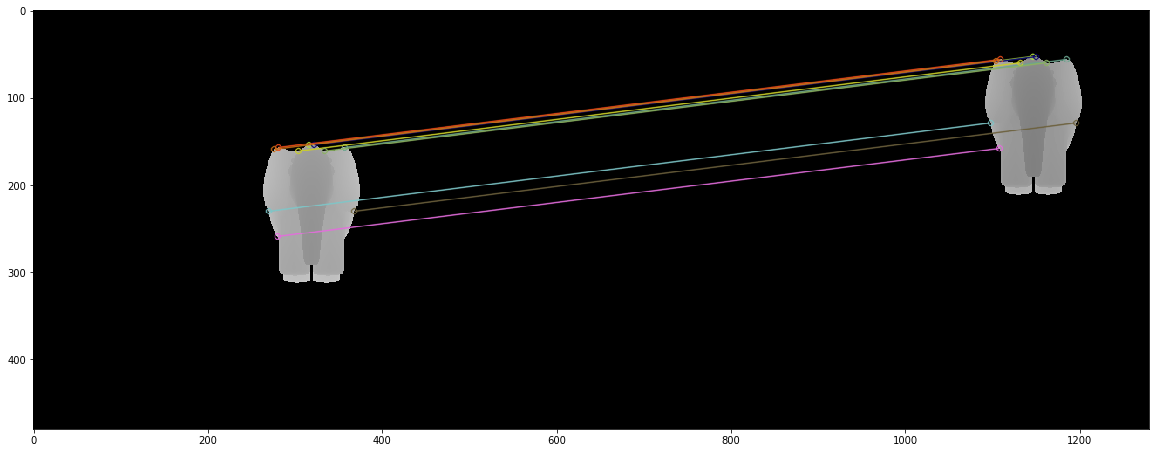

In [19]:
# sanity check for using simple_match

orb = cv2.ORB_create()

target_img = Image.open("images/targets/{}/target_depth.png".format("elephant")).convert('RGB')
target = np.array(target_img)


heap_img = Image.open("images/targets/{}/target_depth_shifted.png".format("elephant")).convert('RGB')
heap = np.array(heap_img)

kp1, des1 = orb.detectAndCompute(target,None)

kp2, des2 = orb.detectAndCompute(heap,None)
draw_orb_matches(target, kp1, des1, heap, kp2, des2, num_matches=10, match_type='simple')

(480, 640, 3)
Using openCV norm_hamming


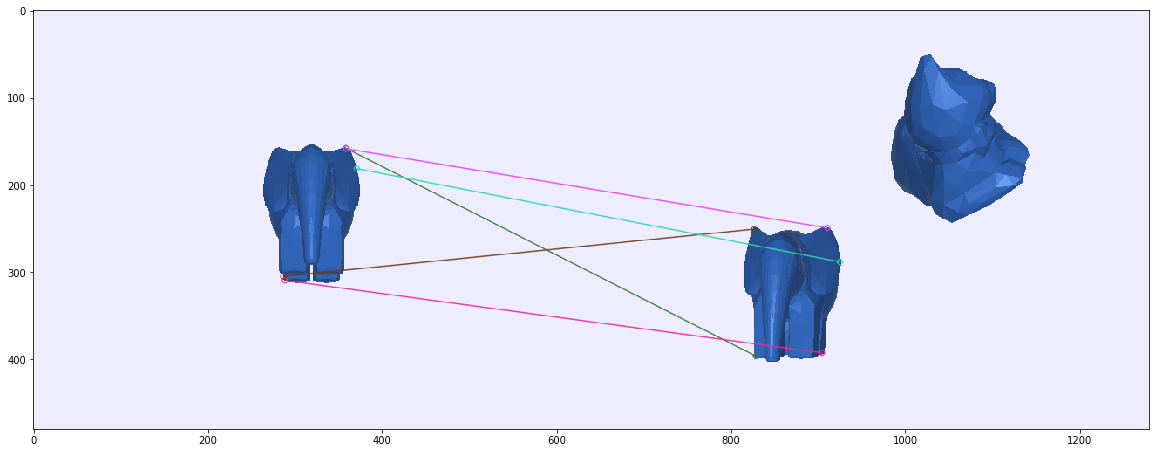

In [20]:
# Initiate ORB detector
orb = cv2.ORB_create()

target_img = Image.open("simple_target/elephant.png").convert('RGB')
target = np.array(target_img)
print(target.shape)
target_easy_img = Image.open("simple_target/elephant_same.png").convert('RGB')
target_easy = np.array(target_easy_img)

target_mask = np.load("simple_target/target_elephant_mask.npy").astype(np.uint8)
target_easy_mask = np.load("simple_target/heap_elephant_mask.npy").astype(np.uint8)

# target = target * target_mask

heap_img = Image.open("simple_target/elephant_cat.png").convert('RGB')
heap = np.array(heap_img)

kp1, des1 = orb.detectAndCompute(target,None)
kp2, des2 = orb.detectAndCompute(heap,None)
draw_orb_matches(target, kp1, des1, heap, kp2, des2, num_matches=5)

In [21]:
config_filename = os.path.join(utils.getDenseCorrespondenceSourceDir(), 'config', 
                               'dense_correspondence', 'evaluation', 'evaluation.yaml')
config = utils.getDictFromYamlFilename(config_filename)
dce = DenseCorrespondenceEvaluation(config)
DCE = DenseCorrespondenceEvaluation
dcn = dce.load_network_from_config("elephant_rgb_3")
dataset = dcn.load_training_dataset()

Using SpartanDataset:
   - in train mode
   - number of scenes 1
   - total images:     3730


In [22]:
# rgb_filename = "/home/davidtseng/pytorch-dense-correspondence/data_volume/pdc/logs_proto/elephant_rgb/processed/images/001010_rgb.png"
# test_img = Image.open(rgb_filename).convert('RGB')
# x = run_dcn_on_image(dcn, dataset, test_img)
# plt.imshow(x)

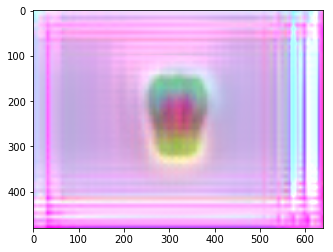

In [23]:
target_descriptors = run_dcn_on_image(dcn, dataset, target_img)
plt.imshow(target_descriptors)

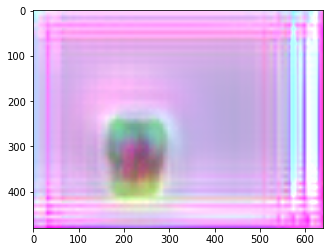

In [24]:
target_easy_descriptors = run_dcn_on_image(dcn, dataset, target_easy_img)
plt.imshow(target_easy_descriptors)

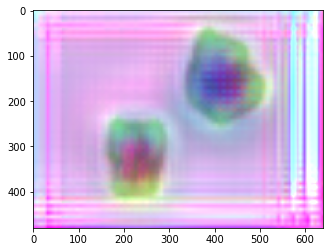

In [25]:
heap_descriptors = run_dcn_on_image(dcn, dataset, heap_img)
plt.imshow(heap_descriptors)

In [26]:
# # find the keypoints with ORB
# kp1 = orb.detect(target,None)
# kp1, des1 = orb.compute((target_descriptors * 255).astype(np.uint8), kp1)

# kp2 = orb.detect(heap,None)
# kp2, des2 = orb.compute((heap_descriptors * 255).astype(np.uint8), kp2)

# draw_orb_matches(target, kp1, des1, heap, kp2, des2, num_matches=5)

# plt.figure()
# plt.imshow(target_descriptors)

# plt.figure()
# plt.imshow(heap_descriptors)

In [27]:
# heap_mask_1 = np.load("simple_target/heap_elephant_mask.npy").astype(np.bool)
# heap_mask_2 = np.load("simple_target/heap_cat_mask.npy").astype(np.bool)
# heap_mask = np.logical_or(heap_mask_1, heap_mask_2).astype(np.uint8)
# np.save("images/heaps/heap_mask.npy", heap_mask)

# DCE.single_image_pair_qualitative_analysis(dcn, dataset, target, heap, target_mask, heap_mask, 5)

In [28]:
# DCE.single_image_pair_qualitative_analysis(dcn, dataset, target_easy, heap, target_easy_mask, heap_mask, 5)

In [32]:
cat_mask = np.load("images/targets/cat/target_mask.npy").astype(np.bool)
cat_img = Image.open("images/targets/cat/target_rgb.png").convert('RGB')
cat = np.array(cat_img)

# print(1/0)
DCE.single_image_pair_qualitative_analysis(dcn, dataset, cat, heap, cat_mask, heap_mask, 5)

NameError: name 'heap_mask' is not defined

In [ ]:
blackshoes_img = Image.open("images/targets/blackshoes/blackshoes.png").convert('RGB')
blackshoes = np.array(blackshoes_img)

blackshoes_mask = np.load("images/targets/blackshoes/blackshoes_mask.npy").astype(np.bool)

cat_blackshoes_mask = np.load("images/heaps/cat_blackshoes/cat_blackshoes_mask.npy").astype(np.bool)


cat_blackshoes_img = Image.open("images/heaps/cat_blackshoes/cat_blackshoes.png").convert('RGB')
cat_blackshoes = np.array(cat_blackshoes_img)

kp1, des1 = orb.detectAndCompute(blackshoes,None)
kp2, des2 = orb.detectAndCompute(cat_blackshoes,None)
draw_orb_matches(blackshoes, kp1, des1, cat_blackshoes, kp2, des2, num_matches=10)
plt.figure()
DCE.single_image_pair_qualitative_analysis(dcn, dataset, blackshoes, cat_blackshoes, blackshoes_mask, cat_blackshoes_mask, 5)
